# Import libraries

In [1]:
import scipy as sc
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from mpl_toolkits import mplot3d
import pandas as pd

# Add real data

In [2]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find growth rate f to first order

In [110]:
#---- USEFUL FUNCTIONS for growth rate f ----

# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(x,alpha_C, k, cosmo):
    return k**2/(k**2 + 6*alpha_C*np.exp(-2*x))
    
# An example of a viable xi from Baker
def xi_ex(x,alpha_C, k, cosmo):
    Omega_c = cosmo['Omega_c']
    Omega_b = cosmo['Omega_b']
    Omega_m = Omega_c + Omega_b
    O_m_GR = Omega_m*np.exp(-3*x)/E(x,cosmo,alpha_C, k)**2
    return 1 + 0.75*(1-O_m_GR) - 1.5*(1-O_m_GR)**2 + 0.75*(1-O_m_GR)**3
    
def E(x,cosmo,alpha_C, k):
    Omega_c = cosmo['Omega_c']
    Omega_b = cosmo['Omega_b']
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*np.exp(-3*x) + (Omega_r + alpha_C)*np.exp(-4*x) + Omega_k*np.exp(-2*x) + Omega_lambda)

def K(x1,x2,cosmo):
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Int = sc.integrate.quad(lambda x: f_LCDM(x,cosmo) + 3*Omega_m*np.exp(-3*x)\
                               /(2*f_LCDM(x,cosmo)), x1, x2)[0]
    return np.exp(Int)

def eta(x_v,cosmo,alpha_C,k):
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Int = sc.integrate.quad(lambda x: (xi(x,alpha_C, k,cosmo) - 1)*Omega_m*np.exp(-3*x)*K(x_v,x,cosmo)\
                               /f_LCDM(x,cosmo), -10 , x_v)[0]
    return 3*Int/2

# derivative of the growth rate f with the logarithm of the scale factor x = ln(a)
# for a LCDM universe
def dfdx_LCDM(f , x , cosmo):
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k
    
    return (3*Omega_m/(2*(Omega_m+Omega_r*np.exp(-x)+Omega_lambda*np.exp(3*x)+Omega_k*np.exp(x))) \
            - f**2 - (2-(3*Omega_m*np.exp(-3*x) + 4*Omega_r*np.exp(-4*x) + 2*Omega_k*np.exp(-2*x))/ \
                      (2*(Omega_k*np.exp(-2*x) + Omega_m*np.exp(-3*x) + Omega_r*np.exp(-4*x) + Omega_lambda)))*f)

# f for LCDM universe
# ccl can only give f in ranges 1e-5 < a <= 1, so extend to intergate to smaller a
def f_LCDM(x,cosmo):
    cutoff_ccl = 1e-2
    cutoff = 1e-2
    # if x is a single number
    if isinstance(x, (int, float)) == True:
        # if f can be calculated using ccl
        if np.exp(x) > cutoff_ccl:
            return ccl.growth_rate(cosmo,np.exp(x))
        # manually calculate f
        else:
            x_v = np.linspace(np.log(cutoff), x, int(1e2))
            f_LCDM = odeint(dfdx_LCDM, ccl.growth_rate(cosmo,np.exp(x_v[0])), x_v, \
                            args=(cosmo,), mxstep=int(1e5))
            f_LCDM = np.transpose(f_LCDM)[0][-1]
            return f_LCDM
    # if x is an array
    elif isinstance(x, (list, tuple, np.ndarray)) == True:
        # if f can be calculated using ccl
        if all(i > cutoff_ccl for i in x_val) == True:
            return ccl.growth_rate(cosmo,np.exp(x))
        #manually calculate f
        else:
            x_v = np.linspace(np.log(cutoff), min(x), int(1e2))
            f_LCDM = odeint(dfdx_LCDM, ccl.growth_rate(cosmo,np.exp(x_v[0])), x_v, \
                            args=(cosmo,), mxstep=int(1e5))
            f_LCDM = np.transpose(f_LCDM)[0]
            # enforce monotonically increasing function for calculation
            indx = np.argmin(abs(np.exp(x) - cutoff))
            if pd.Series(x_v).is_monotonic_increasing == True:
                return np.append(np.interp(x[:indx], x_v, f_LCDM), ccl.growth_rate(cosmo,np.exp(x[indx:])))
            else:
                return np.append(np.interp(-x[:indx], -x_v, f_LCDM), ccl.growth_rate(cosmo,np.exp(x[indx:])))
    else:
        return "error: x is the incorrect data type"
    
#---- USEFUL FUNCTIONS for Delta(a) and sigma8 -----

# Solves second order ODE for D_+(a)
def solverGrowth_LCDM(y,a,cosmo):
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k
    
    E_val = E(np.log(a), cosmo,0,0)
    
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D/(2*E_val*a**2)]
    return ydot

def solverGrowth_LCDM_bvp(a,y,cosmo):
    Omega_k = cosmo['Omega_k']
    Omega_r = cosmo['Omega_g']
    Omega_m = cosmo['Omega_c'] + cosmo['Omega_b']
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k
    
    E_val = E(np.log(a), cosmo,0,0)
    
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D/(2*E_val*a**2)]
    return ydot

0.0


/tmp/ipykernel_929763/3046369530.py:24: RuntimeWarning: overflow encountered in exp
  return np.sqrt(Omega_m*np.exp(-3*x) + (Omega_r + alpha_C)*np.exp(-4*x) + Omega_k*np.exp(-2*x) + Omega_lambda)


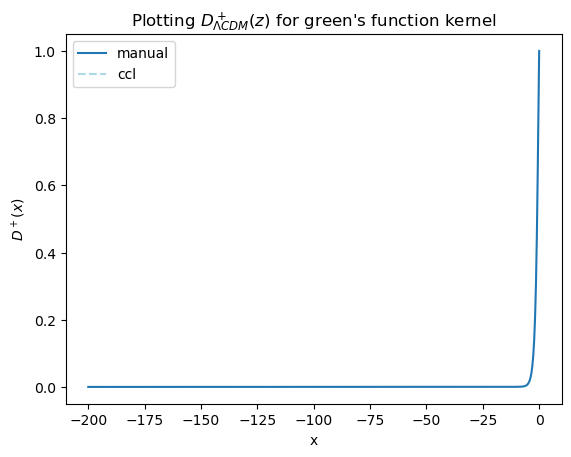

In [111]:
# Decide on some background cosmology
# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400
p = 3
x_val = np.linspace( -200, 0 , int(10**p))
k_val = np.linspace(4, 3e5*np.pi/200, int(10**p + 1))
a_val = np.exp(x_val)
z_val = 1/a_val - 1
# Background cosmology for pyccl
cosmo = ccl.core.Cosmology(Omega_c=0.27,
                           Omega_b=0.045, 
                           sigma8=0.81,
                           h = 0.67,
                           n_s=0.96,
                           Omega_k=0.0, 
                           Omega_g=9.227e-5)


Soln = odeint(solverGrowth_LCDM,[0,1e-10],\
                    a_val,args=(cosmo,),mxstep=int(1e5)).T

# Attempted boundary value problem - doesn't work
#def bc(ya, yb):
#    return np.array([ya[0], yb[0] - 1])

#Soln = solve_bvp(lambda x, y: solverGrowth_LCDM_bvp(x,y,cosmo), bc, a_val, [Soln[0]/Soln[0][-1], Soln[1]/Soln[0][-1]])
#plt.plot(x_val,Soln.sol(x_val)[0])

#Soln_Delta = Soln[0]
#Soln_f = Soln[1]/(Soln[0]*E(x_val,cosmo,0, 0)*a_val**2)

plt.plot(x_val, Soln_Delta/Soln_Delta[-1], label = "manual")
plt.plot(x_val[9000:], ccl.growth_factor(cosmo,a_val[9000:]), label = "ccl", \
         color = "lightblue", linestyle ="--")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$D^+(x)$")
plt.title("Plotting $D^+_{\Lambda CDM}(z)$ for green's function kernel")
print(Soln_Delta[0]/Soln_Delta[-1])

In [112]:
f_val = f_LCDM(x_val,cosmo)

/tmp/ipykernel_929763/3046369530.py:47: RuntimeWarning: overflow encountered in exp
  - f**2 - (2-(3*Omega_m*np.exp(-3*x) + 4*Omega_r*np.exp(-4*x) + 2*Omega_k*np.exp(-2*x))/ \
/tmp/ipykernel_929763/3046369530.py:48: RuntimeWarning: overflow encountered in exp
  (2*(Omega_k*np.exp(-2*x) + Omega_m*np.exp(-3*x) + Omega_r*np.exp(-4*x) + Omega_lambda)))*f)
/tmp/ipykernel_929763/3046369530.py:47: RuntimeWarning: invalid value encountered in double_scalars
  - f**2 - (2-(3*Omega_m*np.exp(-3*x) + 4*Omega_r*np.exp(-4*x) + 2*Omega_k*np.exp(-2*x))/ \


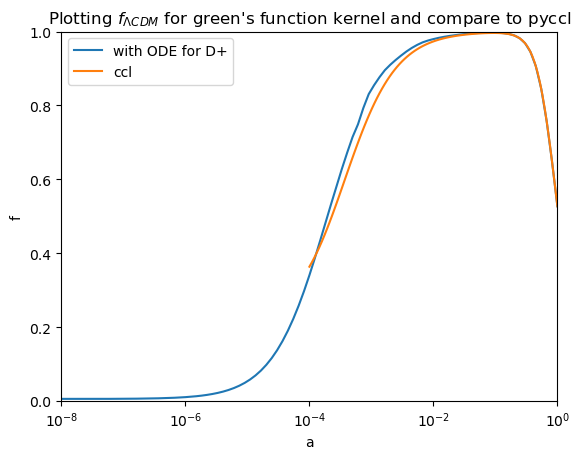

In [113]:
#plt.plot(a_val, f_val, label = "with ODE for f")
plt.plot(a_val, Soln_f, label = "with ODE for D+")
plt.plot(np.logspace(-4,0,100),ccl.growth_rate(cosmo,np.logspace(-4,0,100)), label = "ccl")

plt.xscale("log")
plt.xlabel("a")
plt.ylabel("f")
plt.title(r"Plotting $f_{\Lambda CDM}$ for green's function kernel and compare to pyccl")
plt.legend()
plt.xlim(1e-8,1)
plt.ylim(0,1)
plt.show()

error in k_simga8 =  0.08488263631567752 %


Text(0, 0.5, '$\\xi(z)$')

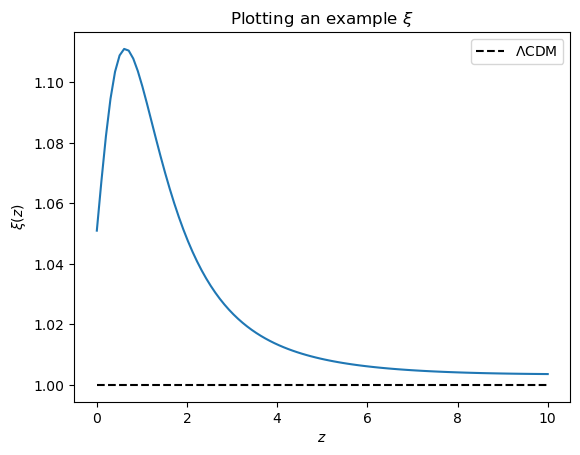

In [136]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")



plt.plot(np.linspace(0,10,100),xi_ex(np.log(1/(1+np.linspace(0,10,100))),0, 0, cosmo))
plt.plot(np.linspace(0,10,100),np.ones(100), "k--", label = r"$\Lambda$CDM")

plt.title(r"Plotting an example $\xi$")
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"$\xi(z)$")

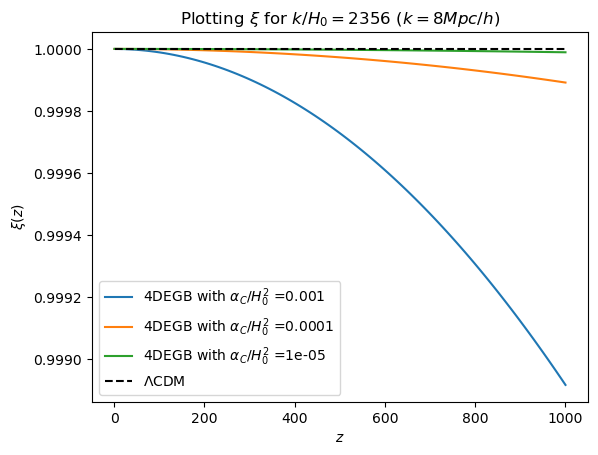

In [154]:
#Plotting our xi

plt.plot(np.linspace(1,1000,100),xi(np.log(1/(1+np.linspace(1,1000,100))),1e-3, 2356, cosmo), label = r"4DEGB with $\alpha_C/H_0^2$ ={}".format(1e-3))
plt.plot(np.linspace(1,1000,100),xi(np.log(1/(1+np.linspace(1,1000,100))),1e-4, 2356, cosmo), label = r"4DEGB with $\alpha_C/H_0^2$ ={}".format(1e-4))
plt.plot(np.linspace(1,1000,100),xi(np.log(1/(1+np.linspace(1,1000,100))),1e-5, 2356, cosmo), label = r"4DEGB with $\alpha_C/H_0^2$ ={}".format(1e-5))

plt.plot(np.linspace(1,1000,100),np.ones(100), "k--", label = r"$\Lambda$CDM")
plt.title(r"Plotting $\xi$ for $k/H_0 = 2356$ $(k = 8 Mpc/h)$")
plt.xlabel(r"$z$")
plt.ylabel(r"$\xi(z)$")
plt.legend()
plt.show()

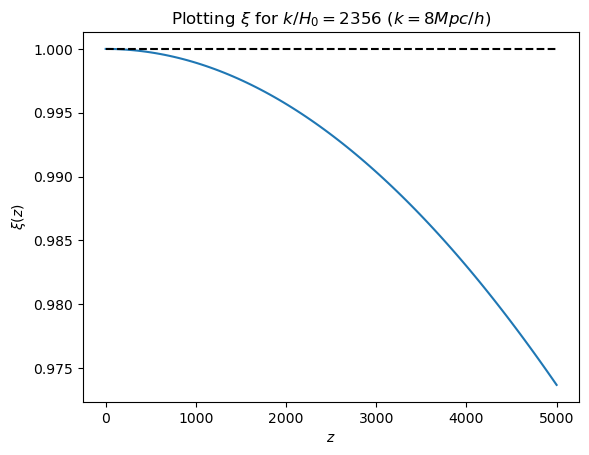

In [159]:
#Plotting our xi

plt.plot(np.linspace(1,5000,100),xi(np.log(1/(1+np.linspace(1,5000,100))),1e-3, 2356, cosmo), label = r"4DEGB with $\alpha_C/H_0^2$ ={}".format(1e-3))

plt.plot(np.linspace(1,5000,100),np.ones(100), "k--", label = r"$\Lambda$CDM")
plt.title(r"Plotting $\xi$ for $k/H_0 = 2356$ $(k = 8 Mpc/h)$")
plt.xlabel(r"$z$")
plt.ylabel(r"$\xi(z)$")
plt.show()